### Daytum +2 Course: Data Analytics, Geostatistics and Machine Learning Deep Dive

### k Nearest Neighbour Demonstration and Exercise

#### Goal

Data imputation with ensemble tree methods.

#### Description

Here's a simple, documented workflow, demonstration of a $k$ nearest neighbour methods for data imputation for subsurface modeling workflows. This should help you get started with building subsurface models that integrate machine learning to fill in missing features. 

#### K Nearest Neighbours

Machine learning method for supervised learning for classification and regression analysis.  Here are some key aspects of $k$ nearest neighbours.

**Prediction**

* non-parametric method for regression and classification

* a function $\hat{f}$ of the nearest $k$ training data in predictor feature space such that we predict a response feature $Y$ from a set of predictor features $X_1,\ldots,X_m$. 

* the prediction is of the form $\hat{Y} = \hat{f}(X_1,\ldots,X_m)$ 

* for classification the majority response category among the $k$ nearest training data is selected as the prediction

* for regression the average (or other weighted average, like inverse distance weighted) of the response features among the $k$ nearest training data is assigned as the prediction 

**Suppervised Learning**

* the response feature label, $Y$, is available over the training and testing data

**Instance-based Learning / Lazy Learning**

* the prediction function is approximated locally and calculation is defered until a prediction is needed

* there is no compact 'model'.  The model is the training data and the hyperparameters
    
**Hyperparameters**

* **$k$ number of nearest data** to utilize for prediction

* **data weighting**, for example uniform weighting (use local training data average), inverse distance weighting

Note, for the case of inverse distance weighting, the method is analogous to inverse distance weighted interpolation with a maximum number of local data constraint commonly applied for spatial interpolation.  Inverse distance is available in GeostatsPy for spatial mapping.

* **distance metric** - more below

**Distance Metric**

* training data within the predictor feature space are ranked by distance (closest to farthest)

* a variety of distance metrics may be applied, including:


1. euclidian distance 

\begin{equation}    
d_i = \sqrt{\sum_{\alpha = 1}^{m} \left(x_{\alpha,i} - x_{\alpha,0}\right)^2} 
\end{equation}

2. overlap metric / Hamming distance used for discrete variables
    
3. correlation coefficients used for comparing sets and images 

##### Why Cover k Nearest Neighbour Regression and Classification?

The method is simple and flexible

* very understandable, interpretable  

* accessible introduction to the concepts of tuning hyperparameters and overfit


#### Workflow Goals

Learn the basics of k nearest neighbour in Python to for multivariate prediction. This includes:

* Loading and visualizing sample data
* Trying out k nearest neighbours for prediction
* Tuning the k nearest neighbours hyperparameters and evaluation of model performance 

#### Objective 

In this workflow I want to provide hands-on experience with building subsurface modeling workflows. Python provides an excellent vehicle to accomplish this. I have coded a package called GeostatsPy with GSLIB: Geostatistical Library (Deutsch and Journel, 1998) functionality that provides basic building blocks for building subsurface modeling workflows. 

The objective is to remove the hurdles of subsurface modeling workflow construction by providing building blocks and sufficient examples. This is not a coding class per se, but we need the ability to 'script' workflows working with numerical methods.    

#### Import Required Packages

We will also need some standard packages. 


In [1]:
import os                                                   # to set current working directory 
import math                                                 # basic calculations like square root
from sklearn.neighbors import KNeighborsRegressor           # for nearest k neighbours
from sklearn import metrics                                 # measures to check our models
from sklearn.model_selection import cross_val_score         # cross validation methods
import pandas as pd                                         # DataFrames and plotting
import pandas.plotting as pd_plot
import numpy as np                                          # arrays and matrix math
import matplotlib.pyplot as plt                             # plotting
from subprocess import check_call
from sklearn.model_selection import train_test_split        # train and test split

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Declare functions

Let's define a couple of functions to streamline plotting correlation matrices and visualization of a decision tree regression model. 

In [2]:
def plot_corr(dataframe,size=10):                               # plots a graphical correlation matrix 
    corr = dataframe.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.matshow(corr,vmin = -1.0, vmax = 1.0)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.colorbar(im, orientation = 'vertical')
    plt.title('Correlation Matrix')
    
def visualize_model(model,xfeature,x_min,x_max,yfeature,y_min,y_max,response,z_min,z_max,title,):# plots the data points and the decision tree prediction 
    n_classes = 10
    cmap = plt.cm.RdYlBu
    plot_step = 0.02
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap,vmin=z_min, vmax=z_max, levels=np.linspace(z_min, z_max, 100))

    im = plt.scatter(xfeature,yfeature,s=None, c=response, marker=None, cmap=cmap, norm=None, vmin=z_min, vmax=z_max, alpha=0.8, linewidths=0.3, edgecolors="black")
    plt.title(title)
    plt.xlabel(xfeature.name)
    plt.ylabel(yfeature.name)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(response.name, rotation=270, labelpad=20)
    
def check_model(model,xfeature,yfeature,response,title):    # plots the estimated vs. the actual  
    predict_train = model.predict(np.c_[xfeature,yfeature])
    plt.scatter(response,predict_train,s=None, c='red',marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=0.3, edgecolors="black")
    plt.title(title); plt.xlabel('Actual Production (MCFPD)'); plt.ylabel('Estimated Production (MCFPD)')
    plt.xlim(0,7000); plt.ylim(0,7000)
    plt.arrow(0,0,7000,7000,width=0.02,color='black',head_length=0.0,head_width=0.0)
    MSE = metrics.mean_squared_error(response,predict_train)
    Var_Explained = metrics.explained_variance_score(response,predict_train)
    cor = math.sqrt(metrics.r2_score(response,predict_train))
    print('Mean Squared Error on Training = ', round(MSE,2),', Variance Explained =', round(Var_Explained,2),'Cor =', round(cor,2))

#### Read the data table 

In [3]:
my_data = pd.read_csv('https://raw.githubusercontent.com/daytum/intake-data/refs/heads/master/daytum_cat/data/unconv_MV.csv')

Let's visualize the first several rows of our data stored in a DataFrame so we can make sure we successfully loaded the data file.

In [4]:
my_data[:7]                                                 # preview the first 7 rows of the dataframe

,WellIndex,Por,LogPerm,AI,Brittle,TOC,VR,Production
0,1,15.91,1.67,3.06,14.05,1.36,1.85,177.381958
1,2,15.34,1.65,2.60,31.88,1.37,1.79,1479.767778
2,3,20.45,2.02,3.13,63.67,1.79,2.53,4421.221583
3,4,11.95,1.14,3.90,58.81,0.40,2.03,1488.317629
4,5,19.53,1.83,2.57,43.75,1.40,2.11,5261.094919
5,6,19.47,2.04,2.73,54.37,1.42,2.12,5497.005506
6,7,12.70,1.30,3.70,43.03,0.45,1.95,1784.266285


Let's remove the well index and check the summary summary statistics.

In [5]:
my_data = my_data.iloc[:,1:8]                               # copy all rows and columns 1 through 8, note 0 column is removed
my_data.describe().transpose()                              # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
Por,1000.0,14.950460,3.029634,5.400000,12.85750,14.98500,17.080000,24.65000
LogPerm,1000.0,1.398880,0.405966,0.120000,1.13000,1.39000,1.680000,2.58000
AI,1000.0,2.982610,0.577629,0.960000,2.57750,3.01000,3.360000,4.70000
Brittle,1000.0,49.719480,15.077006,-10.500000,39.72250,49.68000,59.170000,93.47000
TOC,1000.0,1.003810,0.504978,-0.260000,0.64000,0.99500,1.360000,2.71000
VR,1000.0,1.991170,0.308194,0.900000,1.81000,2.00000,2.172500,2.90000
Production,1000.0,2247.295809,1464.256312,2.713535,1191.36956,1976.48782,3023.594214,12568.64413


It is good that we checked the summary statistics, because we have some negative values for brittleness and total organic carbon. The is physically imposible.  The values must be in error. We know the lowest possible values are 0.0, so we will truncate on 0.0.  We use the *get_numerical_data()* DataFrame member function to get a shallow copy of the data from the DataFrame.  Since it is a shallow copy, any changes we make to the copy are made to the data in the original DataFrame.  This allows us to apply this simple conditional statement to all the data values in the DataFrame all at once.

In [6]:
num = my_data._get_numeric_data()                           # get the numerical values
num[num < 0] = 0                                            # truncate negative values to 0.0
my_data.describe().transpose()                              # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
Por,1000.0,14.950460,3.029634,5.400000,12.85750,14.98500,17.080000,24.65000
LogPerm,1000.0,1.398880,0.405966,0.120000,1.13000,1.39000,1.680000,2.58000
AI,1000.0,2.982610,0.577629,0.960000,2.57750,3.01000,3.360000,4.70000
Brittle,1000.0,49.731480,15.033593,0.000000,39.72250,49.68000,59.170000,93.47000
TOC,1000.0,1.006170,0.499838,0.000000,0.64000,0.99500,1.360000,2.71000
VR,1000.0,1.991170,0.308194,0.900000,1.81000,2.00000,2.172500,2.90000
Production,1000.0,2247.295809,1464.256312,2.713535,1191.36956,1976.48782,3023.594214,12568.64413


#### Standardizing Predictor Features

The k-nearest neighbour method uses a nearest training sample search in feature space (like k-means clustering). To remove the impact feature range from the approach we standardize the features.

* we will standardize our predictor features to have a mean of zero and a variance of one.

* we use the scikikt learn preprocessing to simplify this step and provid a reverse transform.

In [7]:
from sklearn.preprocessing import StandardScaler

transform = StandardScaler(); 

features = ['Por','Brittle']

my_data['sPor'] = transform.fit_transform(my_data.loc[:,features].values)[:,0] # standardize the data features to mean = 0, var = 1.0
my_data['sBrittle'] = transform.fit_transform(my_data.loc[:,features].values)[:,1] # standardize the data features to mean = 0, var = 1.0
my_data.head()

,Por,LogPerm,AI,Brittle,TOC,VR,Production,sPor,sBrittle
0,15.91,1.67,3.06,14.05,1.36,1.85,177.381958,0.316877,-2.374638
1,15.34,1.65,2.60,31.88,1.37,1.79,1479.767778,0.128641,-1.188034
2,20.45,2.02,3.13,63.67,1.79,2.53,4421.221583,1.816157,0.927622
3,11.95,1.14,3.90,58.81,0.40,2.03,1488.317629,-0.990866,0.604184
4,19.53,1.83,2.57,43.75,1.40,2.11,5261.094919,1.512338,-0.398073


Let's demonstrate the reverse transform from standarized back to the original units.

* we won't need this in our workflow since the we only need to forward transform the predictor features to train the model and make predictions

In [8]:
invfeatures = ['sPor','sBrittle']
transform.inverse_transform(my_data.loc[:,invfeatures])

array([[15.91, 14.05],
       [15.34, 31.88],
       [20.45, 63.67],
       ...,
       [15.55, 58.25],
       [20.89, 46.17],
       [15.74, 73.08]])

We can compare the output above with the original porosity and brittleness. The reverse transform works! We will use it to return to the original feature units.

#### Feature Ranges

Let's set some ranges for plotting. Note for the standardized predictor features we will use -3.5 to 3.5 as the limits.

In [9]:
pormin = 5.0; pormax = 25.0                                 # set minumums and maximums for visualization 
brittlemin = 0.0; brittlemax = 100.0
prodmin = 0.0; prodmax = 13000.0

This dataset has variables from 1,000 unconventional wells including well average porosity, log transform of permeability (to linearize the relationships with other variables), accoustic impedance (kg/m2s*10^6), brittness ratio (%), total organic carbon (%), vitrinite reflectance (%), and initial production 90 day average (MCFPD).  Note, the dataset is synthetic.

#### Calculate the correlation matrix 

For multivariate analysis it is a good idea to check the correlation matrix.  We can calculate it and view it in the console with these commands.

In [10]:
corr_matrix = np.corrcoef(my_data, rowvar = False)
print(np.around(corr_matrix,2))                             # print the correlation matrix to 2 decimals

[[ 1.    0.81 -0.51 -0.25  0.71  0.08  0.69  1.   -0.25]
 [ 0.81  1.   -0.32 -0.15  0.51  0.05  0.57  0.81 -0.15]
 [-0.51 -0.32  1.    0.17 -0.55  0.49 -0.33 -0.51  0.17]
 [-0.25 -0.15  0.17  1.   -0.24  0.3  -0.07 -0.25  1.  ]
 [ 0.71  0.51 -0.55 -0.24  1.    0.31  0.5   0.71 -0.24]
 [ 0.08  0.05  0.49  0.3   0.31  1.    0.14  0.08  0.3 ]
 [ 0.69  0.57 -0.33 -0.07  0.5   0.14  1.    0.69 -0.07]
 [ 1.    0.81 -0.51 -0.25  0.71  0.08  0.69  1.   -0.25]
 [-0.25 -0.15  0.17  1.   -0.24  0.3  -0.07 -0.25  1.  ]]


Note the 1.0 diagonal resulting from the correlation of each variable with themselves.  

Let's use our function declared above to make a graphical correlation matrix visualization.  This may inprove our ability to spot features.  It relies on the built in correlation matrix method with Numpy DataFrames and MatPlotLib for plotting.

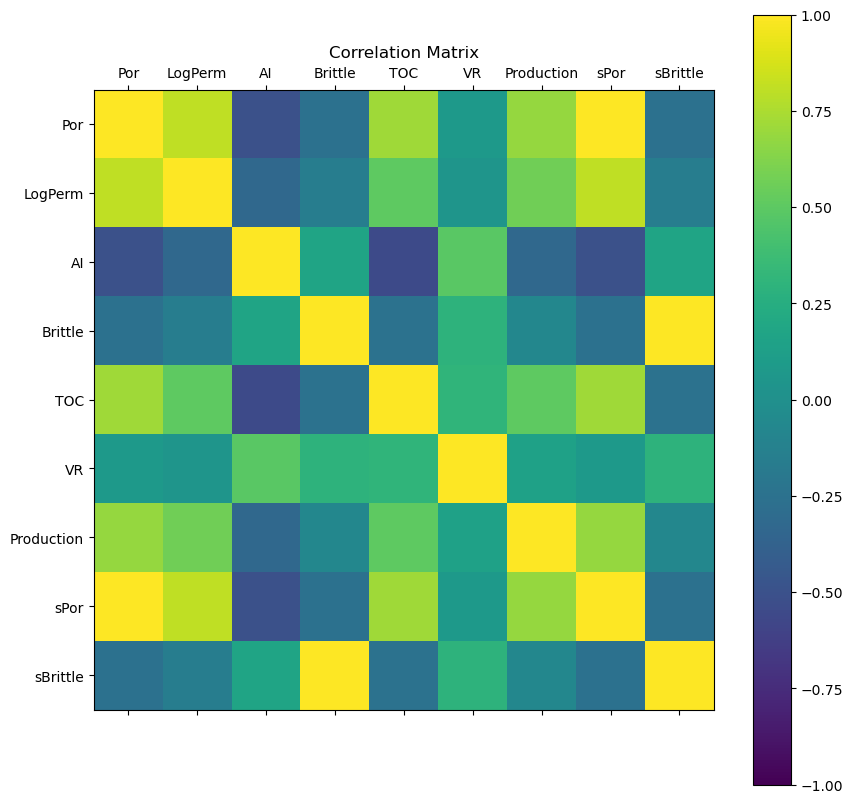

In [11]:
plot_corr(my_data,10)                                       # using our correlation matrix visualization function
plt.show()

This looks good.  There is a mix of correlation magnitudes. Of course, correlation coeffficients are limited to degree of linear correlations.  For more complete information, let's look at the matrix scatter plot from the Pandas package. 

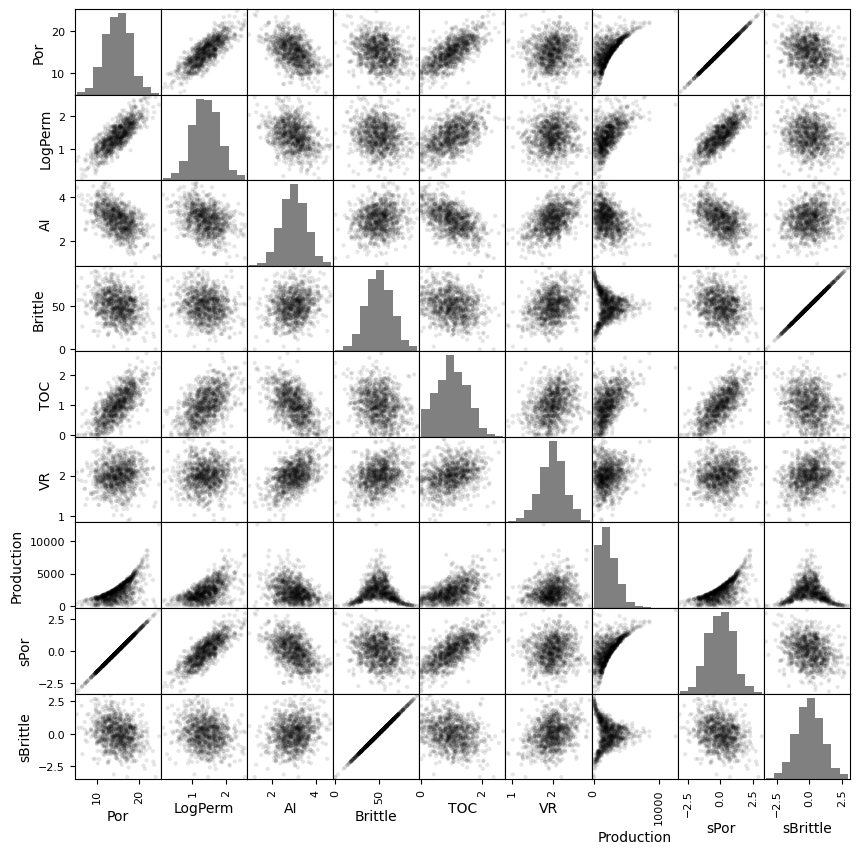

In [12]:
pd_plot.scatter_matrix(my_data, alpha = 0.1,                # pandas matrix scatter plot
    figsize=(10, 10),color = 'black', hist_kwds={'color':['grey']})
plt.show()

#### Working with Only Two Predictor Features

Let's simplify the problem to 2 predictor features, Porosity and Brittleness to predict Production rate.  We will also reduce the number of wells from 1,000 to 500.  By working with only 2 features, it is very easy to visualize the segmentation of the feature space (it is only 2D and can be shown compleltely on a single plot).

In [13]:
my_data_subset = my_data.iloc[:,[7,8,6]]                    # extract just por, brittle and prod with 100 samples
X_train, X_test, y_train, y_test = train_test_split(my_data_subset.iloc[:,[0,1]], my_data_subset.iloc[:,2], test_size=0.25, random_state=73073)
y_train = pd.DataFrame({'Prod':y_train.values})
y_test = pd.DataFrame({'Prod':y_test.values})

Let's first check the univariate statistics of Porosity, Brittleness and Producton.

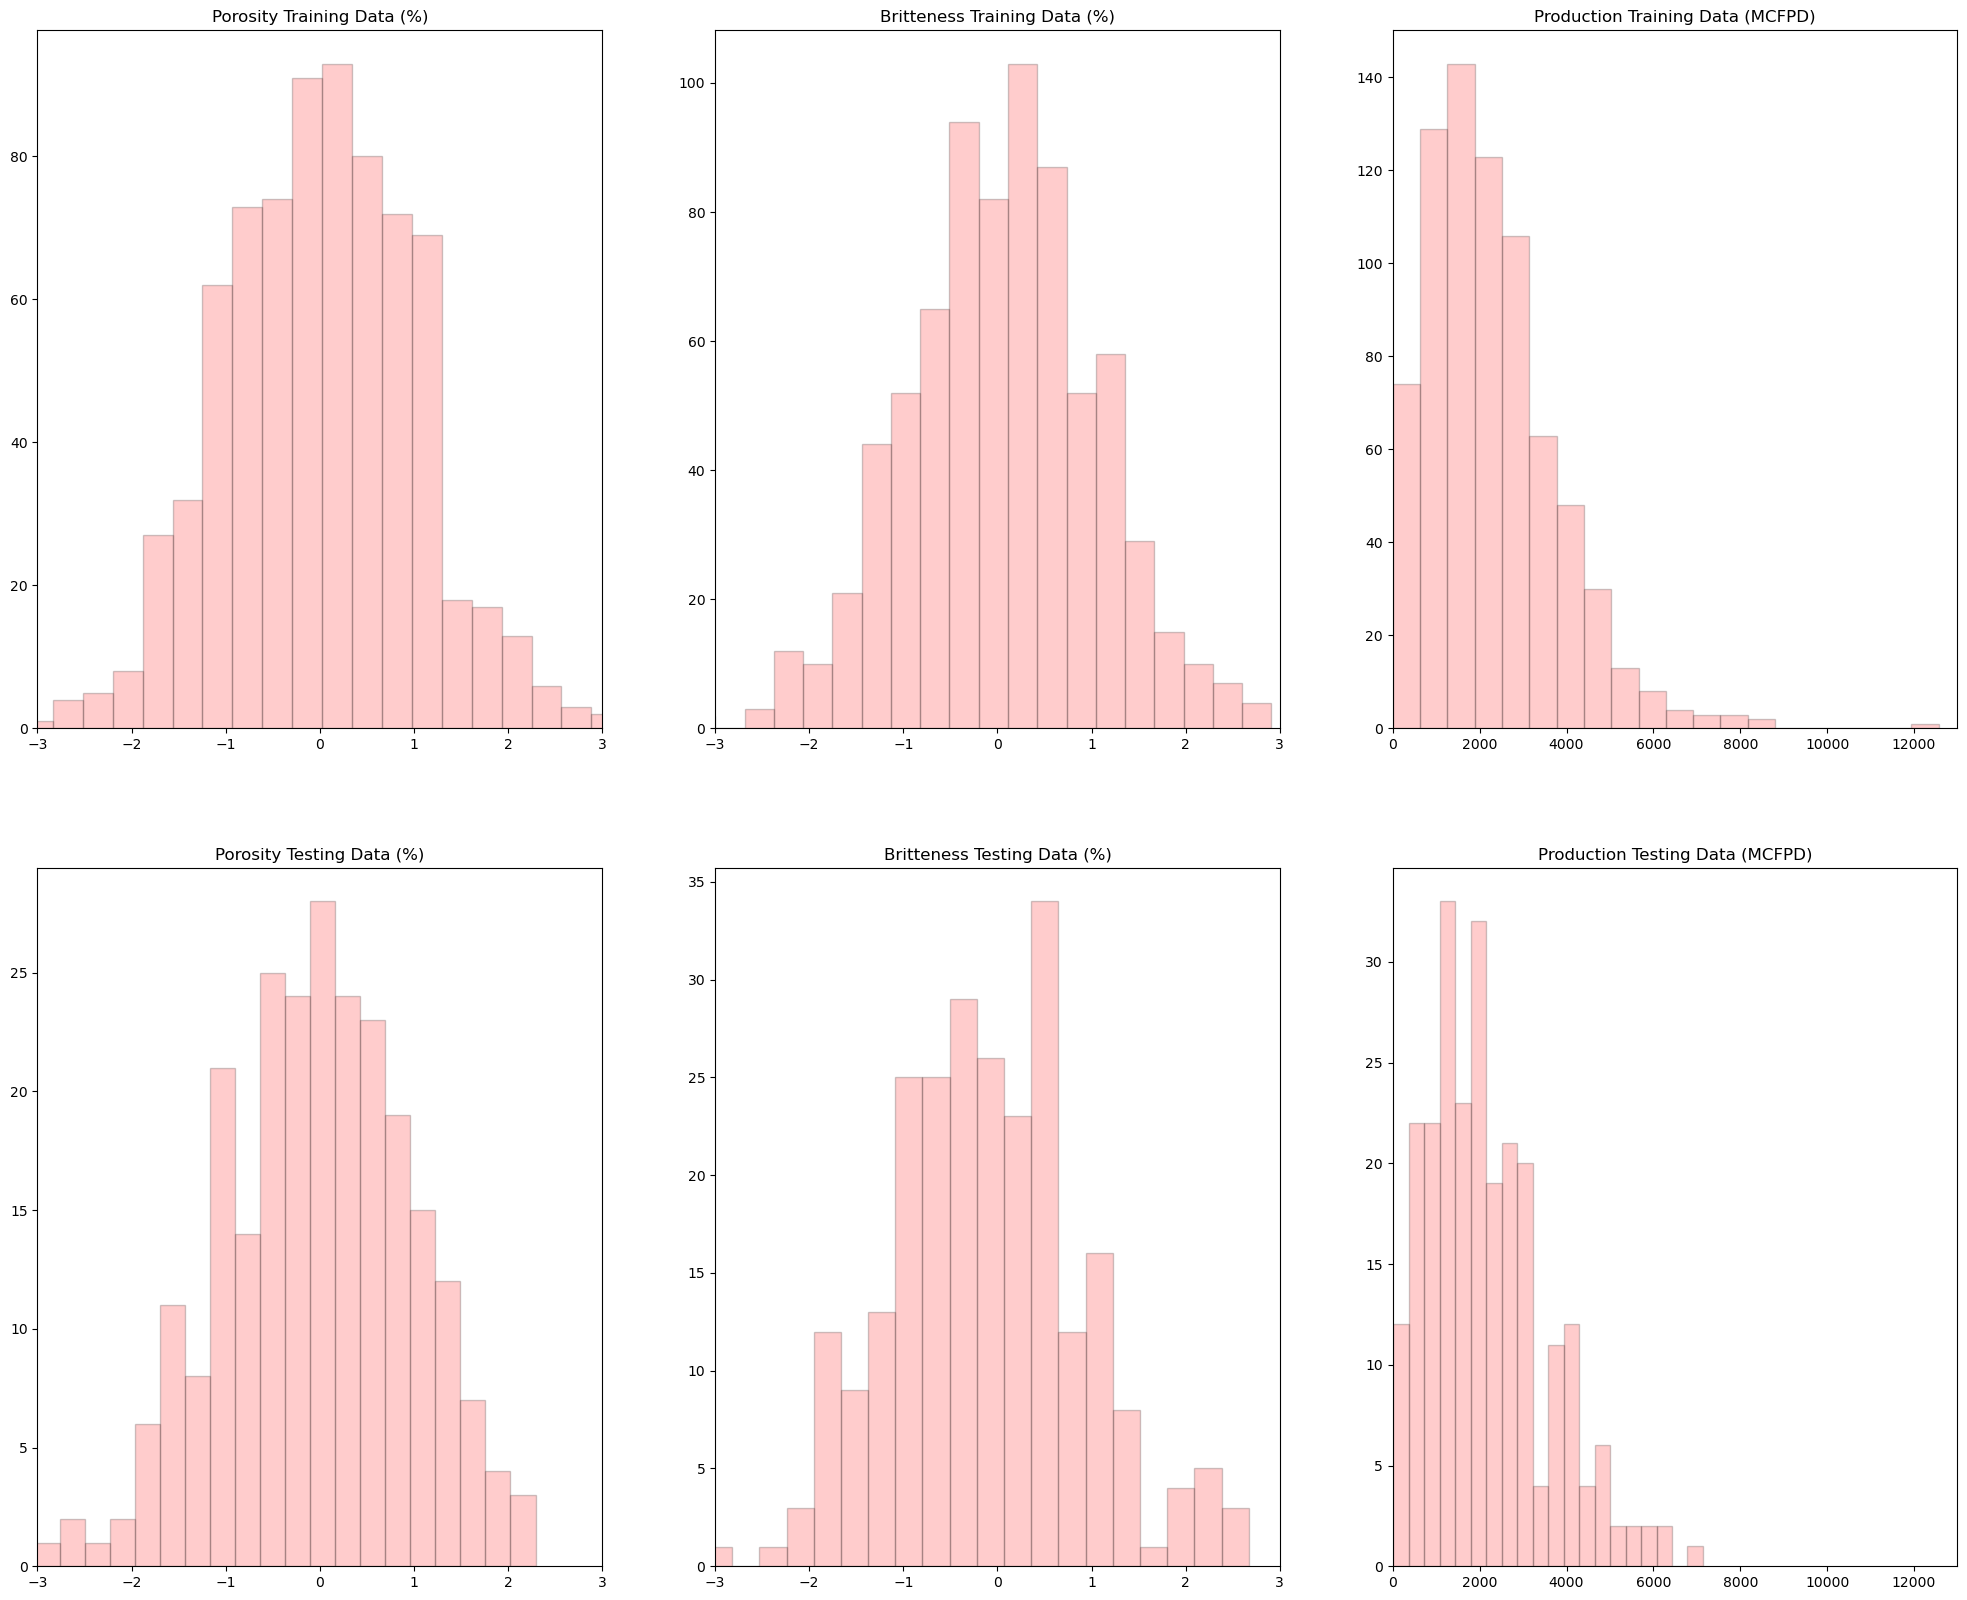

In [14]:
plt.subplot(231)
plt.hist(X_train["sPor"], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title('Porosity Training Data (%)'); plt.xlim(-3,3)

plt.subplot(232)
plt.hist(X_train["sBrittle"], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title('Britteness Training Data (%)'); plt.xlim(-3,3)

plt.subplot(233)
plt.hist(y_train['Prod'], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title('Production Training Data (MCFPD)'); plt.xlim(prodmin,prodmax)

plt.subplot(234)
plt.hist(X_test["sPor"], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title('Porosity Testing Data (%)'); plt.xlim(-3,3)

plt.subplot(235)
plt.hist(X_test["sBrittle"], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title('Britteness Testing Data (%)'); plt.xlim(-3,3)

plt.subplot(236)
plt.hist(y_test['Prod'], alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title('Production Testing Data (MCFPD)'); plt.xlim(prodmin,prodmax)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3.2, wspace=0.2, hspace=0.2)
plt.show()

The distributions are well behaved, we cannot observe obvious gaps nor truncations.  Let's look at a scatter plot of Porosity vs. Brittleness with points colored by Production.

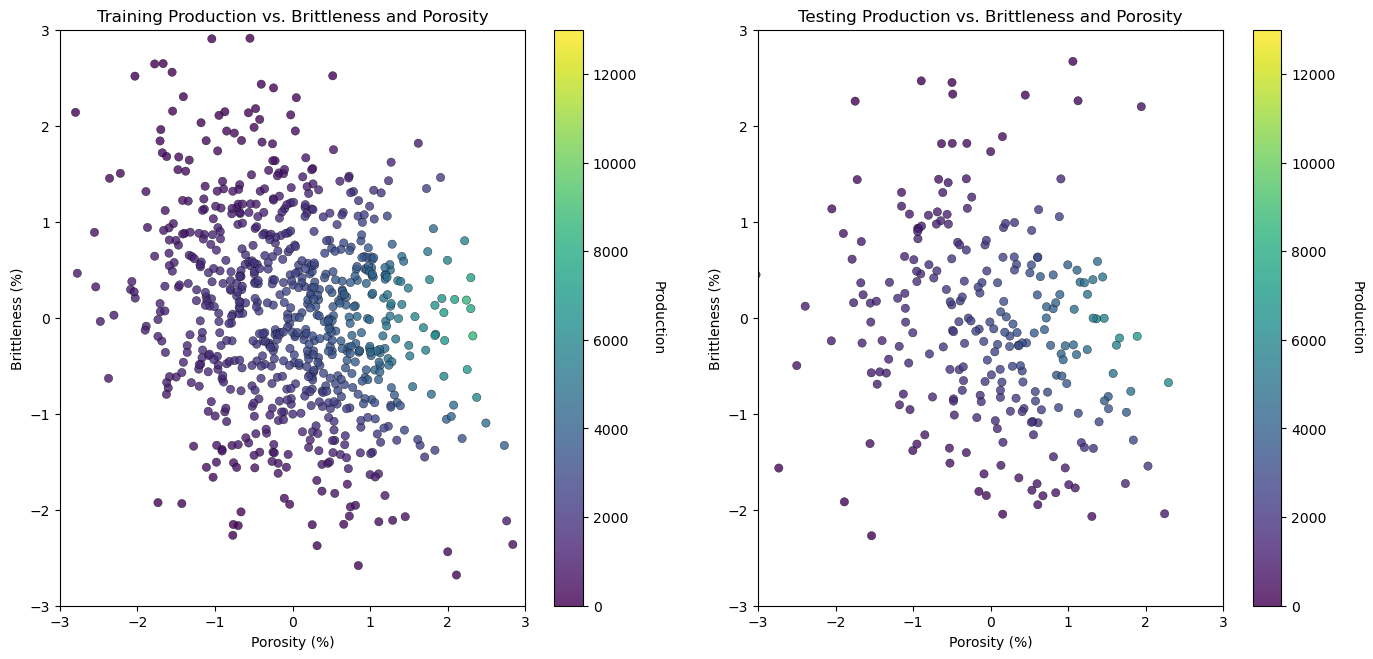

In [16]:
plt.subplot(121)
im = plt.scatter(X_train["sPor"],X_train["sBrittle"],s=None, c=y_train['Prod'], marker=None, cmap=None, norm=None, vmin=prodmin, vmax=prodmax, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.title('Training Production vs. Brittleness and Porosity'); plt.xlabel('Porosity (%)'); plt.ylabel('Brittleness (%)')
plt.xlim(-3,3); plt.ylim(-3,3)
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label("Production", rotation=270, labelpad=20)

plt.subplot(122)
im = plt.scatter(X_test["sPor"],X_test["sBrittle"],s=None, c=y_test['Prod'], marker=None, cmap=None, norm=None, vmin=prodmin, vmax=prodmax, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.title('Testing Production vs. Brittleness and Porosity'); plt.xlabel('Porosity (%)'); plt.ylabel('Brittleness (%)')
plt.xlim(-3,3); plt.ylim(-3,3)
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label("Production", rotation=270, labelpad=20)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

This problem looks complicated and could not be modeled with simple linear regression.  It appears there is a sweet spot for Brittleness and increasing Porosity is always beneficial for Production.

#### Instantiate, Fit and Predict with $k$ Nearest Neighbour

Let's instantiate, fit and predict with a $k$ nearest neighbour model.

* instantiate it with the hyperparameters, $k$ nearest neighbours 

* train with the training data, we use the standard fit funciton from scikit learn 


In [17]:
neigh = KNeighborsRegressor(weights = 'uniform', n_neighbors=5, p = 1) # instantiate the prediction model


We have set the hyperparameters:
* weights = averaging weights for the prediction given the nearest neighbours.  'uniform' is arithmetic average, while 'distance' is inverse distance weighting.

* n_neighbours = maximum number of neighbours. Note, we constrain our prediction by limiting it to 5 nearest neighbours.

* p = distance metric power or Minkowsi metric (1 = Manhattan distance, 2 for Euclidian distance) for finding the nearest neighbours.

Now we are ready to fit our model for prediction of Production given Porosity and Brittleness.  

* We will use our two functions defined above to visualize the $k$ nearest neighbour prediction over the feature space and the cross plot of actual and estimated production for the training data along with three model metrics from the sklearn.metric module.

/opt/conda/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


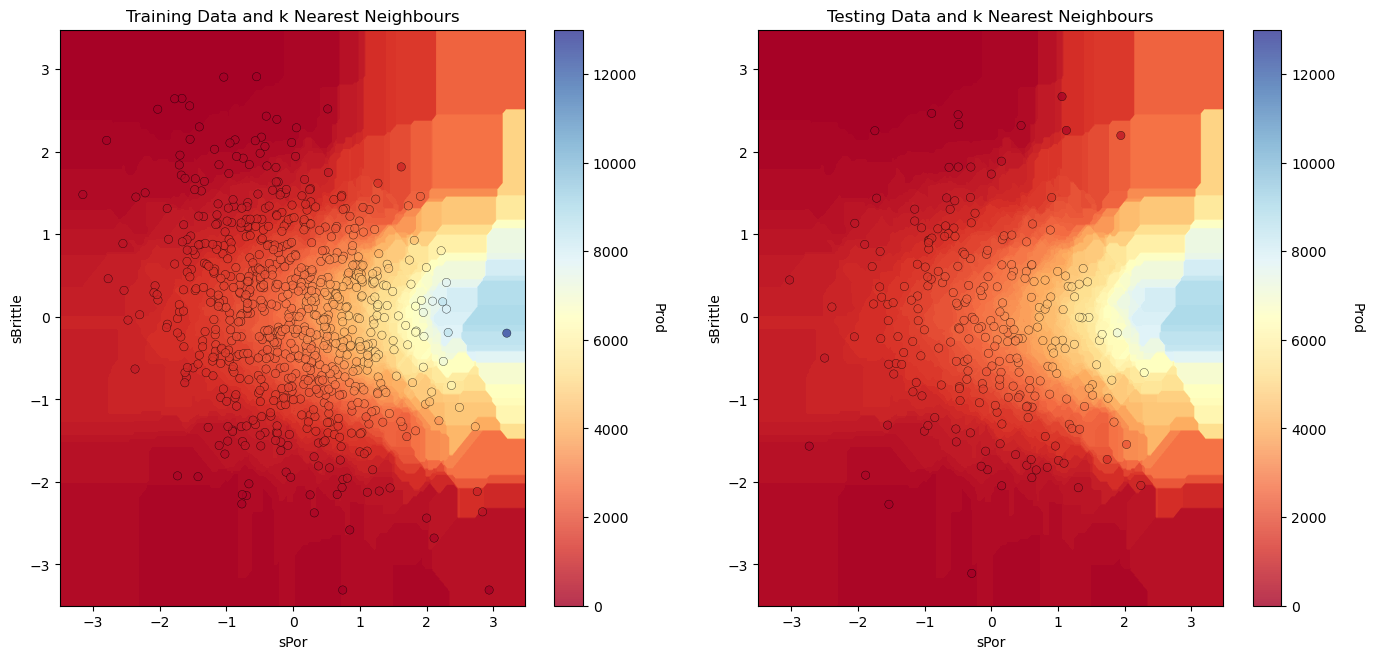

In [18]:
neigh_fit = neigh.fit(X_train,y_train['Prod'])              # train the model with the training data

plt.subplot(121)
visualize_model(neigh_fit,X_train["sPor"],-3.5,3.5,X_train["sBrittle"],-3.5,3.5,y_train["Prod"],prodmin,prodmax,'Training Data and k Nearest Neighbours')

plt.subplot(122)
visualize_model(neigh_fit,X_test["sPor"],-3.5,3.5,X_test["sBrittle"],-3.5,3.5,y_test["Prod"],prodmin,prodmax,'Testing Data and k Nearest Neighbours')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

The model looks good:

* the nonparametric approach is quite flexible to fit the nonlinear response patterns in the predictor feature space

* we can see some search artifacts due to limited k nearest data and the use of uniform weighting

* note the horizontal lines, this is due to the difference in range of the two features resulting in brittleness differences having more weight - we could consider standarizing the features to have the same range or variance to assign equal importance

Let's go ahead and look at the cross validation results.

/opt/conda/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


Mean Squared Error on Training =  36412.89 , Variance Explained = 0.98 Cor = 0.99
Mean Squared Error on Training =  37211.14 , Variance Explained = 0.98 Cor = 0.99


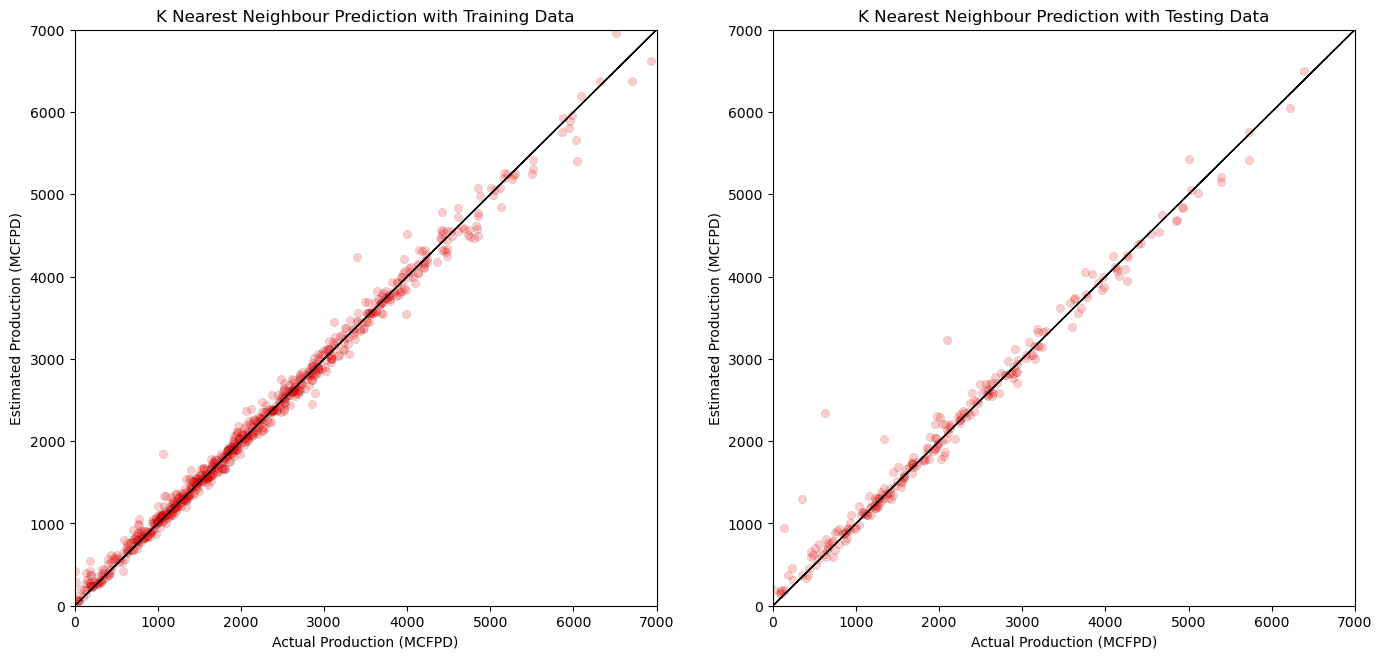

In [19]:
plt.subplot(121)
check_model(neigh_fit,X_train["sPor"],X_train["sBrittle"],y_train["Prod"],'K Nearest Neighbour Prediction with Training Data')

plt.subplot(122)
check_model(neigh_fit,X_test["sPor"],X_test["sBrittle"],y_test["Prod"],'K Nearest Neighbour Prediction with Testing Data')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

The training performed well and the testing even a little better!  Is this expected?  Yes.

* we have dense data for this low dimensional problem (only 2 predictor features)

* the testing and training data are consistent and close to each other in the predictor feature space

Let's repeat with inverse distance weighting.

/opt/conda/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


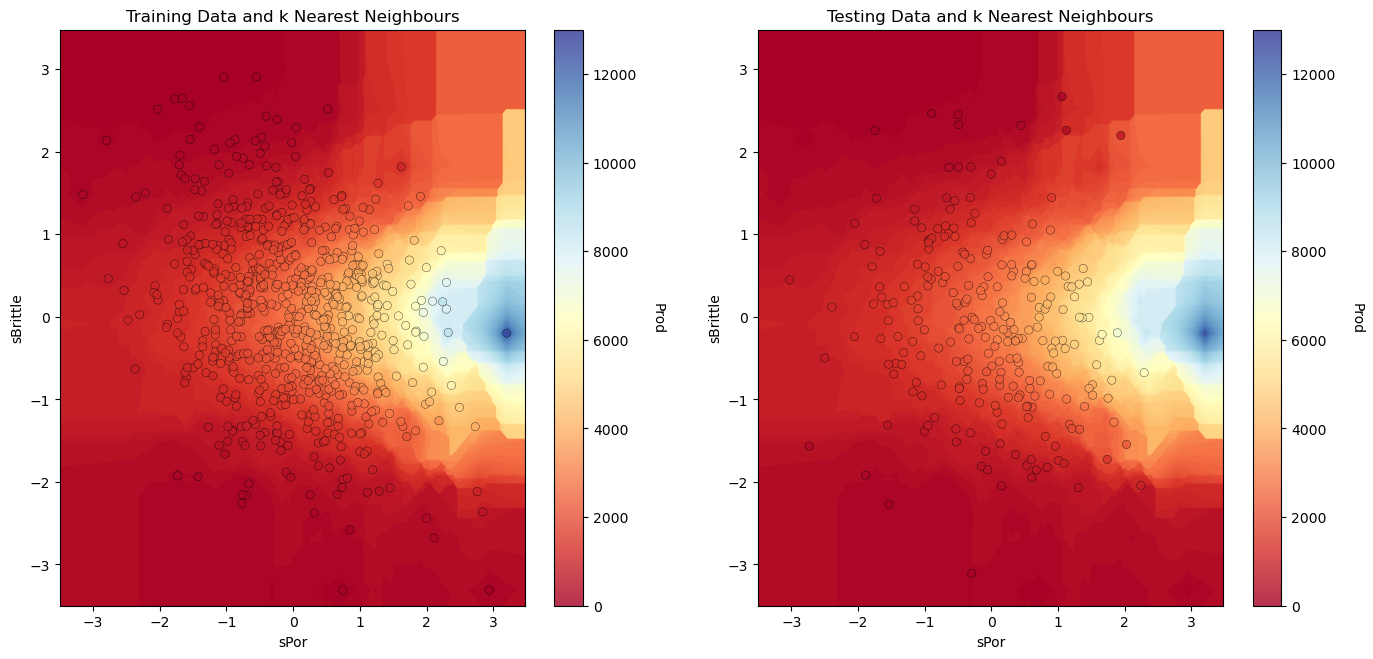

In [20]:
neigh = KNeighborsRegressor(weights = 'distance', n_neighbors=5, p = 1)

neigh_fit = neigh.fit(X_train,y_train['Prod'])              # train the model with the training data

plt.subplot(121)
visualize_model(neigh_fit,X_train["sPor"],-3.5,3.5,X_train["sBrittle"],-3.5,3.5,y_train["Prod"],prodmin,prodmax,'Training Data and k Nearest Neighbours')

plt.subplot(122)
visualize_model(neigh_fit,X_test["sPor"],-3.5,3.5,X_test["sBrittle"],-3.5,3.5,y_test["Prod"],prodmin,prodmax,'Testing Data and k Nearest Neighbours')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

Note that this smoothed out the response, removed some discontinuity 'artifacts' in the model prediction over the predictor feature space.

Next let's use a larger $k$ nearest neighbours for our predictions.  

/opt/conda/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


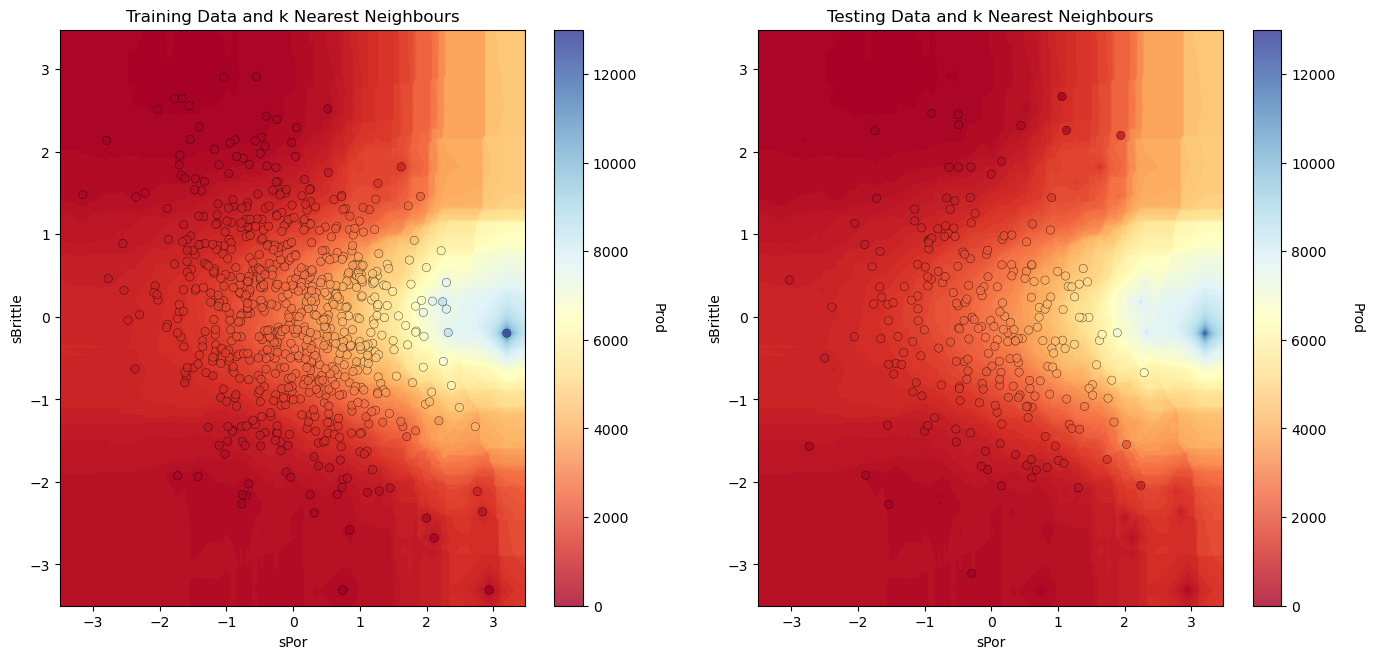

In [21]:
neigh = KNeighborsRegressor(weights = 'distance', n_neighbors=15, p = 1)

neigh_fit = neigh.fit(X_train,y_train['Prod'])              # train the model with the training data

plt.subplot(121)
visualize_model(neigh_fit,X_train["sPor"],-3.5,3.5,X_train["sBrittle"],-3.5,3.5,y_train["Prod"],prodmin,prodmax,'Training Data and k Nearest Neighbours')

plt.subplot(122)
visualize_model(neigh_fit,X_test["sPor"],-3.5,3.5,X_test["sBrittle"],-3.5,3.5,y_test["Prod"],prodmin,prodmax,'Testing Data and k Nearest Neighbours')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

Now we are getting a much more smooth set of predictions over the predictor feature space.  

* There is much more that could be attempted like working with other weighting (for calculating the predicted response feature) and distance metrics (for pooling the k nearest neighbours).

Let's go extreme and check out the model with only the nearest neighbour, $k = 1$.  

/opt/conda/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


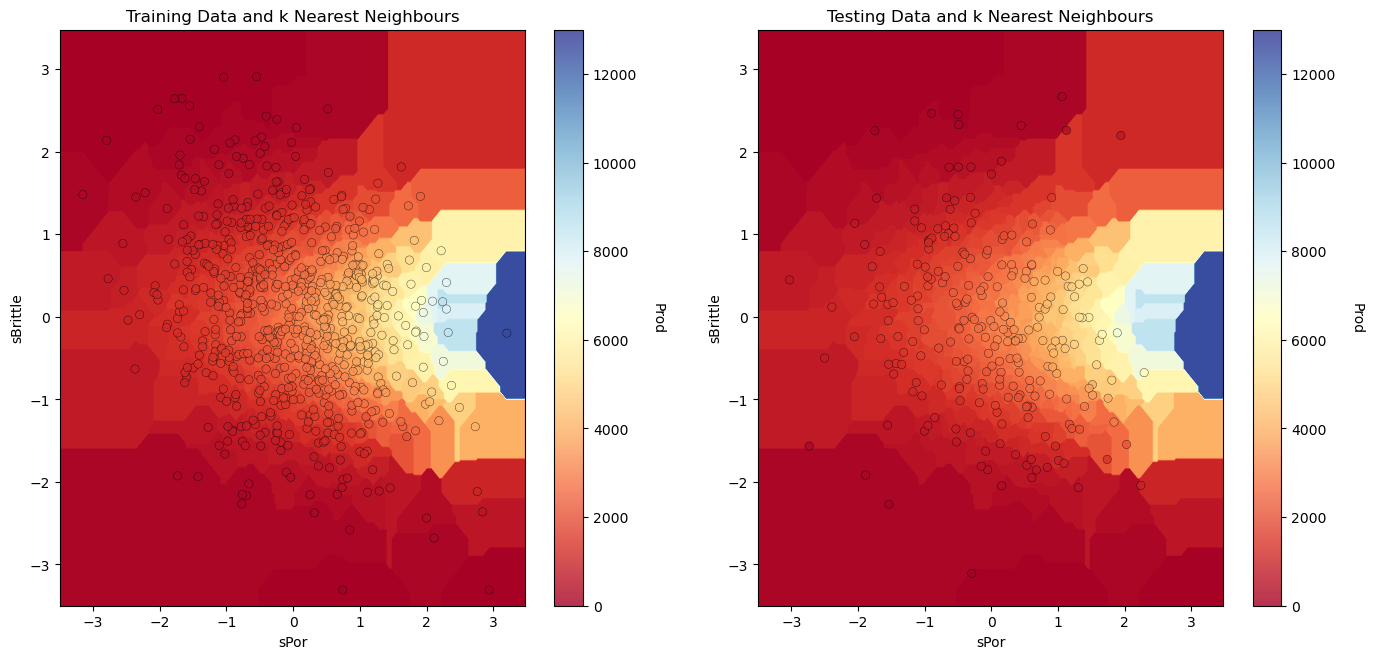

In [22]:
neigh = KNeighborsRegressor(weights = 'distance', n_neighbors=1, p = 1)

neigh_fit = neigh.fit(X_train,y_train['Prod'])              # train the model with the training data 

plt.subplot(121)
visualize_model(neigh_fit,X_train["sPor"],-3.5,3.5,X_train["sBrittle"],-3.5,3.5,y_train["Prod"],prodmin,prodmax,'Training Data and k Nearest Neighbours')

plt.subplot(122)
visualize_model(neigh_fit,X_test["sPor"],-3.5,3.5,X_test["sBrittle"],-3.5,3.5,y_test["Prod"],prodmin,prodmax,'Testing Data and k Nearest Neighbours')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

This model is very fit the local training data in the predictor feature space, it is likely overfit. Let's check this out as we tune the hyper parameters.

So what does the $k$ do?

* small $k$ hyperparameter results in a local specfic prediction model over the predictor feature space

* large $k$ hyperparameter results in a more smooth, globally fit prediction model over the predictor features space

This is analogous to the low to high complexity we have obseved with other models (like decision trees). 

* small $k$ is complex 

* large $k$ is simple

We need to tune the complexity to optimize model performance.

#### Tuning the Hyperparameters

Let's loop over multiple $k$ nearest neighbours for average and inverse distance estimates to access the best hyperparameters with respect to accuracy in testing.

In [23]:
k = 1
dist_error = []
unif_error = []
k_mat = np.linspace(1,50,50)
while k <= 50:
    neigh_dist = KNeighborsRegressor(weights = 'distance', n_neighbors=k, p = 1)
    neigh_dist_fit = neigh_dist.fit(X_train,y_train['Prod'])    # train the model with the training data
    y_pred = neigh_dist_fit.predict(X_test)
    MSE = metrics.mean_squared_error(y_test,y_pred)
    dist_error.append(MSE)
    
    neigh_unif = KNeighborsRegressor(weights = 'uniform', n_neighbors=k, p = 1)
    neigh_unif_fit = neigh_unif.fit(X_train,y_train['Prod'])    # train the model with the training data
    y_pred = neigh_unif_fit.predict(X_test)
    MSE = metrics.mean_squared_error(y_test,y_pred)
    unif_error.append(MSE)
    k = k + 1

Now let's plot the result.

AttributeError: PathCollection.set() got an unexpected keyword argument 'verts'

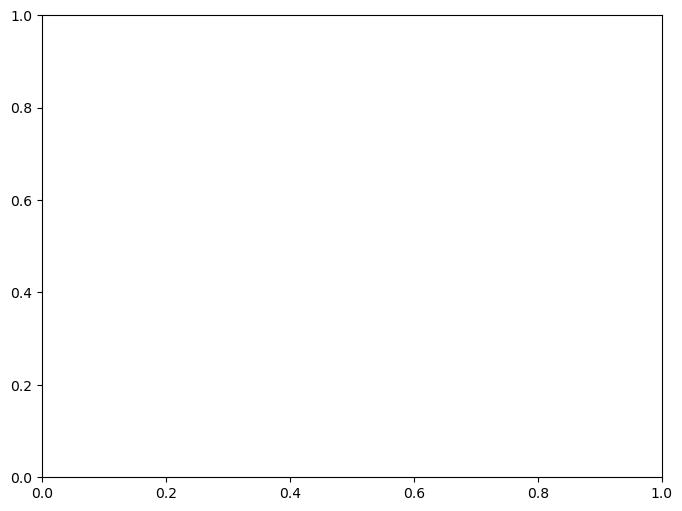

In [24]:
plt.figure(figsize=(8,6))
plt.scatter(k_mat,dist_error,s=None, c='red',label = 'inverse distance weighted', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
plt.scatter(k_mat,unif_error,s=None, c='blue',label = 'arithmetic average', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
plt.title('Testing Error vs. Number of Nearest Neighbours'); plt.xlabel('Number of Nearest Neighbours'); plt.ylabel('Mean Square Error')
plt.legend()
plt.xlim(0,50); plt.ylim(0,200000)
plt.show()

What can we observe from this result?

* at $k = 5$ nearest neighbours we minimize the mean square error in testing.

* we have better performance with the inverse distance weighted than the arithmetic average (uniform weighting of k nearest training data in predictor feature space)

There is an optimum degree of specifivity / complexity to our model.  

* 1 nearest neighbour is a very locally specific model (overfit)

* many nearest neighbours includes too much information and is too general (underfit)

We are observing the accuracy vs. complexity trade-off for the $k$ nearest neighbour model.

#### k-fold Cross Validation

It is useful to evaluate the performance of our model by observing the accuracy vs. complexity trade-off.   

Yet, what we really want to do is rigorously test our model performance.  We should perform a more rigorous cross validation that does a better job evaluating over different sets of training and testing data. scikit learn has a built in cross validation method called cross_val_score that we can use to:

1. Apply k-fold approach with iterative separation of training and testing data
2. Automate the model construction, looping over folds and averaging the metric of interest

Let's try it out on our k nearest neighbour prediction with variable number of $k$ nearest neighbours.  Note the cross validation is set to use 4 processors, but still will likely take a couple of minutes to run.

In [ ]:
score = []                                                  # code modified from StackOverFlow by Dimosthenis
k_mat = []
for k in range(1,30):
    neigh_dist = KNeighborsRegressor(weights = 'distance', n_neighbors=k, p = 1)
    scores = cross_val_score(estimator=neigh_dist, X= np.c_[my_data['sPor'],my_data['sBrittle']],y=my_data['Production'], cv=2, n_jobs=4,scoring = "neg_mean_squared_error") # Perform 7-fold cross validation
    score.append(abs(scores.mean()))
    k_mat.append(k)

The output is an array of average scores (MSE) over the k-folds for each level of complexity (number of $k$ nearest neighbours), along with an array with the $k$s.

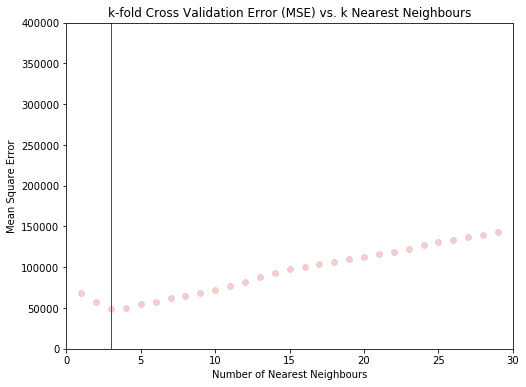

In [ ]:
plt.figure(figsize=(8,6))
plt.arrow(3,0,0,1500000,width=0.02,color='red',head_length=0.0,head_width=0.0)
plt.scatter(k_mat,score,s=None, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=0.5, verts=None, edgecolors="black")
plt.title('k-fold Cross Validation Error (MSE) vs. k Nearest Neighbours'); plt.xlabel('Number of Nearest Neighbours'); plt.ylabel('Mean Square Error')
plt.xlim(0,30); plt.ylim(0,400000)
plt.show()

It is clear that at about 3 nearest neighbours we get the greatest accuracy in k fold cross validation model testing.

* 10 folds of k-fold cross validation

* we could select 3 nearest neighbours for making future predictions

#### Predictor Feature Standardization

We have standardized the predictor feature to remove the influence of their ranges.

* What would happen if we worked with the original predictor features?  

Let's try it out.

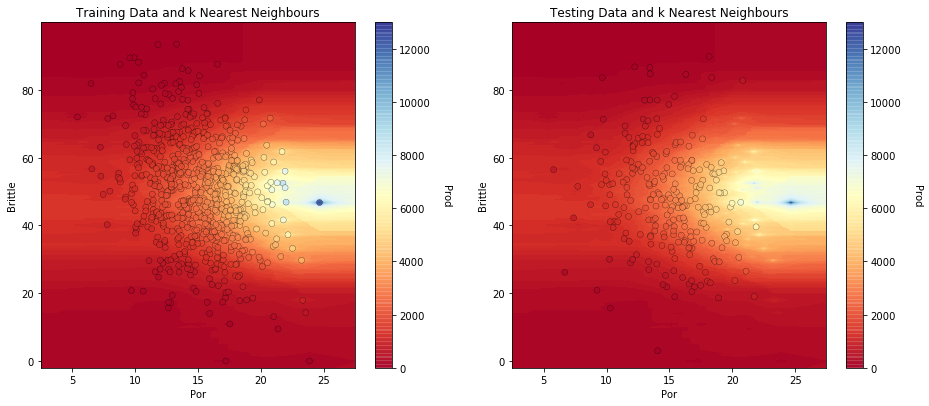

In [ ]:
my_data_subset = my_data.iloc[:,[0,3,6]]                    # extract just por, brittle and prod
X_train, X_test, y_train, y_test = train_test_split(my_data_subset.iloc[:,[0,1]], my_data_subset.iloc[:,2], test_size=0.25, random_state=73073)
y_train = pd.DataFrame({'Prod':y_train.values})
y_test = pd.DataFrame({'Prod':y_test.values})

neigh = KNeighborsRegressor(weights = 'distance', n_neighbors=15, p = 1)
neigh_fit = neigh.fit(X_train,y_train['Prod'])              # train the model with the training data

plt.subplot(121)
visualize_model(neigh_fit,X_train["Por"],pormin-2.5,pormax+2.5,X_train["Brittle"],brittlemin-2,brittlemax,y_train["Prod"],prodmin,prodmax,'Training Data and k Nearest Neighbours')

plt.subplot(122)
visualize_model(neigh_fit,X_test["Por"],pormin-2.5,pormax+2.5,X_test["Brittle"],brittlemin-2,brittlemax,y_test["Prod"],prodmin,prodmax,'Testing Data and k Nearest Neighbours')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

Do you see the horizontal banding?  The larger range of magnitudes of brittleness vs. porosity results in this banding.

* distances in the feature space are more sensitive to the relative changes in brittleness than porosity

Let's convert porosity to a fraction and observe the change in our predictor due to the arbitrary decision to work with porosity as a fraction vs. a percentage.

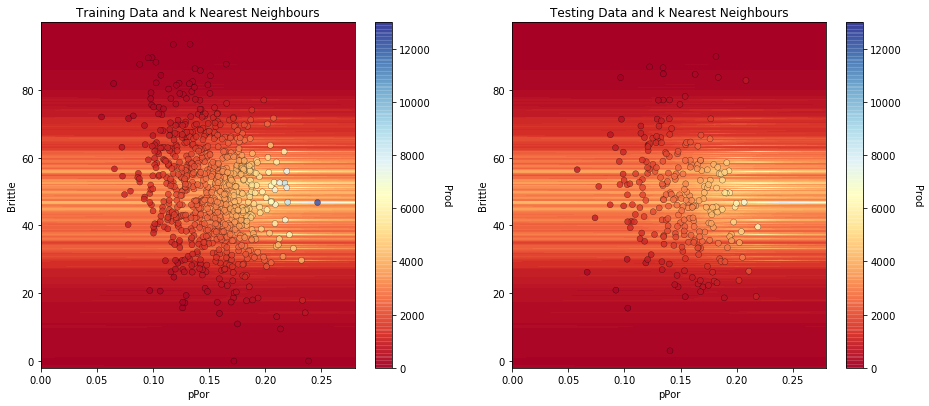

In [ ]:
my_data['pPor'] = my_data['Por']/100
my_data_subset = my_data.iloc[:,[9,3,6]]                    # extract just por, brittle and prod
X_train, X_test, y_train, y_test = train_test_split(my_data_subset.iloc[:,[0,1]], my_data_subset.iloc[:,2], test_size=0.25, random_state=73073)
y_train = pd.DataFrame({'Prod':y_train.values})
y_test = pd.DataFrame({'Prod':y_test.values})

neigh = KNeighborsRegressor(weights = 'distance', n_neighbors=15, p = 1)
neigh_fit = neigh.fit(X_train,y_train['Prod'])              # train the model with the training data

plt.subplot(121)
visualize_model(neigh_fit,X_train["pPor"],0.0,0.3,X_train["Brittle"],brittlemin-2,brittlemax,y_train["Prod"],prodmin,prodmax,'Training Data and k Nearest Neighbours')

plt.subplot(122)
visualize_model(neigh_fit,X_test["pPor"],0.0,0.3,X_test["Brittle"],brittlemin-2,brittlemax,y_test["Prod"],prodmin,prodmax,'Testing Data and k Nearest Neighbours')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

Our distance metric for assigning nearest neighbours is quite sensitive to the feature units.  We should always standardize all predictor features (put them on eequal footing) before we use them to build our $k$-nearest neighbour regression model!

#### Comments

$k$-nearest neighbour regression is a flexbile and simple nonparametric method, by learning about it we were able to:
* work with nonparametric prediction

* explore tuning of hyperparameters

* observe the accuracy - complexity trade-off

<i>&copy; Copyright daytum 2021. All Rights Reserved</i>